# Imports


In [24]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.api.models import Sequential, model_from_json
from keras.api.layers import Dense, Input, Dropout
from keras.api.optimizers import SGD, Adam
from keras.api.losses import BinaryCrossentropy, Hinge
from keras.api.metrics import BinaryAccuracy
from keras.api.activations import relu, tanh

from scikeras.wrappers import KerasClassifier

from matplotlib import pyplot as plt

# Importando o dataset

In [25]:
script_directory ="./"
dataset_path = os.path.join(script_directory, "datasets", "breast_cancer", "data.csv")

# Carregando o banco de dados
dataset = pd.read_csv(dataset_path, index_col='id')
dataset.dropna(axis='columns', inplace=True)

# Separar dataset em entradas e saidas
columns = dataset.columns
out_column = ['diagnosis']
in_columns = columns.drop('diagnosis')

entradas = dataset[in_columns]
entradas = entradas.astype('float32')

# Atualizar valores não numérico para correspondentes numéricos. Facilita o treinamento da rede.
saida = dataset[out_column]
saida.iloc[:, 0] = saida.iloc[:, 0].map({'B': 0, 'M': 1})
saida = saida.astype('float32')

# Separando dados de treino e teste

In [3]:
# Separando dados de treino e teste
pctg_separada_para_teste = 0.25
x_treino, x_teste, y_treino, y_teste = train_test_split(entradas, saida, test_size=pctg_separada_para_teste)

# Criando a rede neural

In [4]:
entradas.shape

(569, 30)

In [8]:
# Criando a rede neural
modelo = Sequential(name="Breast_Cancer")

# Adicionar o número de entradas do dataset
modelo.add(
    Input(
        shape=[30,],
    )
)
modelo.add(
    # DENSE: Todos os neuronios são conectados a todos os outros neuronios da camada subsequente.
    Dense(
        units=16,
        activation="relu",
        kernel_initializer='random_uniform',
        use_bias=False
    )
)
modelo.add(
    Dense(
        units=16,
        activation="relu",
        kernel_initializer='random_uniform',
        use_bias=False
    )
)
modelo.add(
    Dense(
        units=1,
        activation="sigmoid",
        kernel_initializer='random_uniform',
        use_bias=False
    )
)

modelo.compile(
    optimizer=Adam(
        learning_rate=0.00001,
        weight_decay=0.0000000001,
        clipvalue=0.5
    ),
    loss=BinaryCrossentropy(),
    metrics=[
        BinaryAccuracy()
    ]
)

# Treinando a rede neural - Modelo báscio

In [9]:
# Treinando o modelo
history = modelo.fit(
    x=x_treino,
    y=y_treino,
    batch_size=20,
    epochs=500
)

print("\n\n")
print("Precisão de treinamento: ", history.history['binary_accuracy'][-1] * 100, "%")
print("Custo de treinamento: ", history.history['loss'][-1])

Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.3623 - loss: 0.6901   
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.3802 - loss: 0.6777 
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.3907 - loss: 0.6722 
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.3928 - loss: 0.6659 
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.3937 - loss: 0.6685 
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.3999 - loss: 0.6661 
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.3636 - loss: 0.6826 
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.4031 - loss: 0.6601 
Epoch 9/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.3742 - loss: 0.6750 
Epoch 10/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.3472 - loss: 0.6836 
Epoch 11/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accura

## Avaliando desempenho da rede neural

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - binary_accuracy: 0.8770 - loss: 0.4596


Custo de teste:  0.44035667181015015
Precisão de teste:  86.01398468017578 %


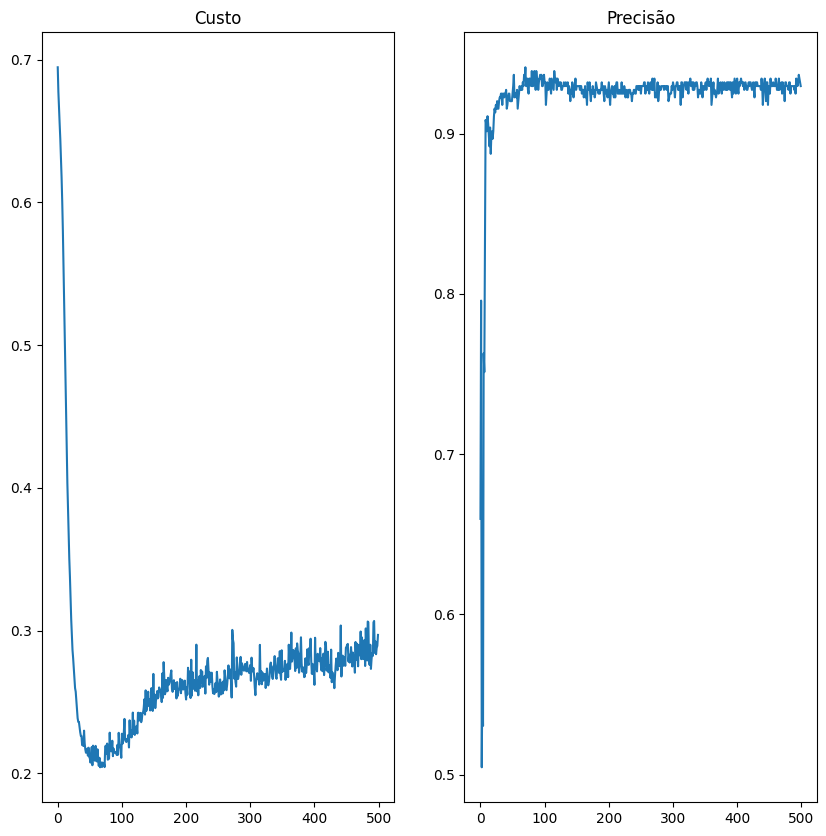

In [10]:
resultado = modelo.evaluate(x_teste, y_teste)

print("\n\nCusto de teste: ", resultado[0])
print("Precisão de teste: ", resultado[1] * 100, "%")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax1 = ax[0]
ax2 = ax[1]
ax1.plot(history.history['loss'], label='Custo')
ax1.set_title('Custo')

ax2.plot(history.history['binary_accuracy'], label='Precisão')
ax2.set_title('Precisão')

plt.show()

# Treinando a rede neural - Método K-fold Cross Validations

In [31]:
def criar_modelo(name="Breast_Cancer") -> Sequential:
    # Criando a rede neural
    modelo = Sequential(name=name)
    modelo.add(
        Input(shape=[30,])
    )
    modelo.add(
        Dense(
            units=16,
            activation="relu",
            kernel_initializer='random_uniform',
            use_bias=False
        )
    )
    modelo.add(
        Dropout(
            rate=0.2
        )
    )
    modelo.add(
        Dense(
            units=16,
            activation="relu",
            kernel_initializer='random_uniform',
            use_bias=False
        )
    )
    modelo.add(
        Dropout(
            rate=0.2
        )
    )
    modelo.add(
        Dense(
            units=1,
            activation="sigmoid",
            kernel_initializer='random_uniform',
            use_bias=False
        )
    )

    modelo.compile(
        optimizer=Adam(
            learning_rate=0.0001,
            weight_decay=0.00000001,
            clipvalue=0.5
        ),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy()
        ]
    )

    return modelo

In [34]:
modelo_validacao_cruzada = KerasClassifier(
    model=criar_modelo,
    epochs=100,
    batch_size=10
)

K = 10 # Número de grupos/repetições que serão feitas no dataset
resultados = cross_val_score(
    estimator=modelo_validacao_cruzada,
    X = entradas,
    y = saida,
    cv = K
)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - binary_accuracy: 0.5542 - loss: 0.6911 
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - binary_accuracy: 0.4673 - loss: 0.6833
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - binary_accuracy: 0.4732 - loss: 0.6775
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - binary_accuracy: 0.4940 - loss: 0.6787
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - binary_accuracy: 0.5082 - loss: 0.6649
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - binary_accuracy: 0.5768 - loss: 0.6492
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - binary_accuracy: 0.6907 - loss: 0.6363
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - binary_accuracy: 0.6448 - loss: 0.6236
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - binary_accuracy: 0.6853 - loss: 0.6044
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - binary_accuracy: 0.7507 - loss: 0.5835
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - bi

Média: 0.9192
Desvio Padrão: 0.0325


C:\Users\joao.turra\AppData\Local\Temp\ipykernel_13044\4195801257.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


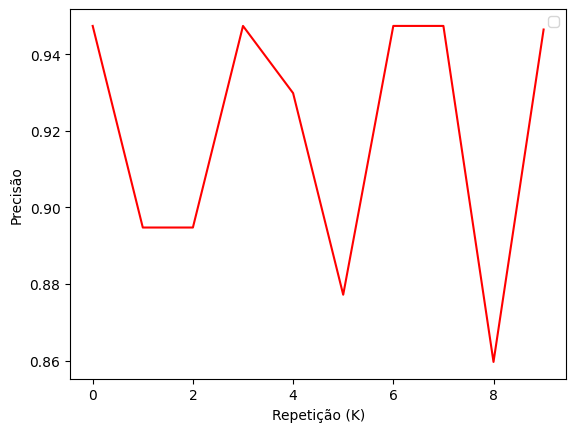

In [35]:
media = np.mean(resultados)
desvio_padrao = np.std(resultados)

print(f"Média: {round(media, 4)}")

# Quanto maior o valor do STD, maior a chance de dar overfitting na rede
print(f"Desvio Padrão: {round(desvio_padrao, 4)}") 

plt.plot(resultados, 'r')
plt.xlabel("Repetição (K)")
plt.ylabel("Precisão")

plt.legend()
plt.show()

# Tunning

In [6]:
def criar_modelo(optimizer, loss, kernel_initializer, activation, neurons, 
                 dropout = 0.2, name="Breast_Cancer", metrics = ['binary_accuracy']) -> Sequential:
    # Criando a rede neural
    modelo = Sequential(name=name)
    modelo.add(
        Input(shape=[30,])
    )
    modelo.add(
        Dense(
            units=neurons,
            activation=activation,
            kernel_initializer=kernel_initializer,
        )
    )
    modelo.add(
        Dropout(
            rate=dropout
        )
    )
    modelo.add(
        Dense(
            units=neurons,
            activation=activation,
            kernel_initializer=kernel_initializer,
        )
    )
    modelo.add(
        Dropout(
            rate=dropout
        )
    )
    modelo.add(
        Dense(
            units=1,
            activation="sigmoid"
        )
    )

    modelo.compile(
        optimizer = optimizer,
        loss = loss,
        metrics = metrics
    )

    return modelo

In [ ]:
modelo = KerasClassifier(model=criar_modelo)

print(modelo.get_params().items())

adam_optimizer = Adam(learning_rate=0.0001, clipvalue=0.5)
sgd_optimizer = SGD(learning_rate=0.0001, clipvalue=0.5, momentum=0.0001)

binary_crossentropy = BinaryCrossentropy()
hinge = Hinge()

parametros = {
    'batch_size': [20],
    'epochs': [100],
    'model__optimizer': [adam_optimizer, sgd_optimizer],
    'model__loss': ['binary_crossentropy'],
    'model__kernel_initializer': ['normal'],
    'model__activation': [relu],
    'model__neurons': [16, 8]
}

K = 5 # Número de grupos/repetições que serão feitas no dataset

grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=parametros,
    scoring=accuracy_score,
    cv= K
)

grid_search.fit(
    X = entradas,
    y = saida
)

In [ ]:
melhores_parametros = grid_search.best_params_
melhor_precisao = grid_search.best_score_

# Classificação de um registro somente

In [5]:
def criar_modelo(optimizer, loss, kernel_initializer, activation, neurons, 
                 dropout = 0.2, name="Breast_Cancer", metrics = ['binary_accuracy']) -> Sequential:
    # Criando a rede neural
    modelo = Sequential(name=name)
    modelo.add(
        Input(shape=[30,])
    )
    modelo.add(
        Dense(
            units=neurons,
            activation=activation,
            kernel_initializer=kernel_initializer,
        )
    )
    modelo.add(
        Dropout(
            rate=dropout
        )
    )
    modelo.add(
        Dense(
            units=neurons,
            activation=activation,
            kernel_initializer=kernel_initializer,
        )
    )
    modelo.add(
        Dropout(
            rate=dropout
        )
    )
    modelo.add(
        Dense(
            units=1,
            activation="sigmoid"
        )
    )

    modelo.compile(
        optimizer = optimizer,
        loss = loss,
        metrics = metrics
    )

    return modelo

In [8]:
modelo = criar_modelo(optimizer='adam', loss='binary_crossentropy', kernel_initializer='normal',
                     activation=relu, neurons=8, dropout=0.2, metrics=['binary_accuracy'])

modelo.fit(
    x=entradas,
    y=saida,
    batch_size=10,
    epochs=100
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.5723 - loss: 0.9607
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6440 - loss: 0.6132
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7524 - loss: 0.5654
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8307 - loss: 0.5061
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8399 - loss: 0.4760
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8443 - loss: 0.4440
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8455 - loss: 0.4373
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8536 - loss: 0.3981
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8868 - loss: 0.3796
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8687 - loss: 0.3568
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8861 -

In [9]:
novo_dado = np.array([
    [15.8, 8.34, 118, 900, 0.1, 0.26, 0.08, 0.134, 0.178, 
     0.20, 0.05, 1098, 0.87, 4500, 145.2, 0.005, 0.04, 0.05, 
     0.015, 0.03, 0.007, 23.15, 16.64, 178.5, 2018, 0.14, 0.185,
     0.84, 158, 0.363]
])

previsao = modelo.predict(x=novo_dado)

print(previsao)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
[[1.]]


# Salvar a Rede Neural

In [14]:
modelo_json = modelo.to_json()

script_directory ="./"
model_file_path = os.path.join(script_directory, "models", "breast_cancer.model.json")
weights_file_path = os.path.join(script_directory, "models", "breast_cancer.weights.h5")

with open(model_file_path, 'w') as json_file:
    json_file.write(modelo_json)

modelo.save_weights(weights_file_path)

# Carregar uma rede neural salva

In [18]:
script_directory ="./"
model_file_path = os.path.join(script_directory, "models", "breast_cancer.model.json")
weights_file_path = os.path.join(script_directory, "models", "breast_cancer.weights.h5")

with open(model_file_path, 'r') as arquivo:
    estrutura = arquivo.read()
    modelo_carregado: Sequential = model_from_json(estrutura)

modelo_carregado.load_weights(weights_file_path)

In [19]:
novo_dado = np.array([
    [15.8, 8.34, 118, 900, 0.1, 0.26, 0.08, 0.134, 0.178, 
     0.20, 0.05, 1098, 0.87, 4500, 145.2, 0.005, 0.04, 0.05, 
     0.015, 0.03, 0.007, 23.15, 16.64, 178.5, 2018, 0.14, 0.185,
     0.84, 158, 0.363]
])

previsao = modelo_carregado.predict(x=novo_dado)

print(previsao)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
[[1.]]


In [21]:
modelo_carregado.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

resultado = modelo_carregado.evaluate(
    x=entradas,
    y=saida
)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8984 - loss: 0.2317  


# Tarefa 1 - Melhorando a eficiência da rede neural
* Utilizando validação cruzada

In [26]:
def criar_modelo(name="Breast_Cancer") -> Sequential:
    # Criando a rede neural
    modelo = Sequential(name=name)
    modelo.add(
        Input(shape=[30,])
    )
    modelo.add(
        Dense(
            units=16,
            activation="relu",
            kernel_initializer='random_uniform',
            use_bias=False
        )
    )
    modelo.add(
        Dropout(
            rate=0.2
        )
    )
    modelo.add(
        Dense(
            units=16,
            activation="relu",
            kernel_initializer='random_uniform',
            use_bias=False
        )
    )
    modelo.add(
        Dropout(
            rate=0.2
        )
    )
    modelo.add(
        Dense(
            units=1,
            activation="sigmoid",
            kernel_initializer='random_uniform',
            use_bias=False
        )
    )

    modelo.compile(
        optimizer=Adam(
            learning_rate=0.0001,
            weight_decay=0.00000001,
            clipvalue=0.5
        ),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy()
        ]
    )

    return modelo

In [27]:
modelo_validacao_cruzada = KerasClassifier(
    model=criar_modelo,
    epochs=100,
    batch_size=10
)

K = 10 # Número de grupos/repetições que serão feitas no dataset
resultados = cross_val_score(
    estimator=modelo_validacao_cruzada,
    X = entradas,
    y = saida,
    cv = K
)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.4971 - loss: 0.7094 
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.4388 - loss: 0.6863
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.4779 - loss: 0.6787
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5060 - loss: 0.6704
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.4957 - loss: 0.6723
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5164 - loss: 0.6613
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6032 - loss: 0.6580
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6635 - loss: 0.6235
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7407 - loss: 0.6154
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8102 - loss: 0.5764
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8078 

Média: 0.9209
Desvio Padrão: 0.0212


C:\Users\joao.turra\AppData\Local\Temp\ipykernel_7876\4195801257.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


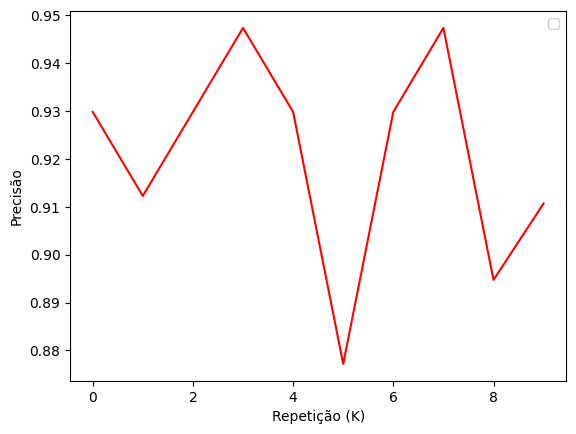

In [28]:
media = np.mean(resultados)
desvio_padrao = np.std(resultados)

print(f"Média: {round(media, 4)}")

# Quanto maior o valor do STD, maior a chance de dar overfitting na rede
print(f"Desvio Padrão: {round(desvio_padrao, 4)}") 

plt.plot(resultados, 'r')
plt.xlabel("Repetição (K)")
plt.ylabel("Precisão")

plt.legend()
plt.show()

In [29]:
modelo.to_json()

'{"module": "keras", "class_name": "Sequential", "config": {"name": "Breast_Cancer", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 30], "dtype": "float32", "sparse": false, "name": "input_layer_1"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Dense", "config": {"name": "dense_3", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "units": 8, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "RandomNormal", "config": {"mean": 0.0, "stddev": 0.05, "seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regula